# 模型选择、欠拟合和过拟合

## 基本代码

可以通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
import d2l_torch as d2l

比如，使用以下三阶多项式来生成训练和测试数据的标签

(**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**)

虽然看起来很复杂，但是画到图上，其实还是只有x和y两个数值

In [21]:
max_degree=20
n_train,n_test=100,100
true_w=np.zeros(max_degree)
# 真实权重维度最大为20维
true_w[0:4]=np.array([5,1.2,-3.4,5.6])
# 其中，真实权重的前四个数，也就是上面三阶多项式每一项的系数,后面就都是0

In [22]:
features=np.random.normal(size=(n_train+n_test,1))
# 这里数据特征/随机生成一个数据集，x就是1维的一个数值
np.random.shuffle(features)
# 逐步生成满足要求的数据集，对数据集中每个元素求0-19次方
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
# 对每个数据添加噪音,poly_features的shape是(200,20)，200行，20列， 
for i in range(max_degree):
    # 相当于对每个feature的每一项幂次除以对应的阶乘
    poly_features[:,i]/=math.gamma(i+1)

# y=wx(系数乘以x，对应相乘，但是这里x次方截至19）
labels=np.dot(poly_features,true_w)   
# 给y加上噪音 正态分布 loc 均值 scale 偏差
labels+=np.random.normal(scale=0.1,size=labels.shape)

# 可以看到，这里特征和系数，也就是x和w的关系，其实是一个线性模型+噪声

In [23]:
# 再进行一波数据转换
true_w,features,poly_features,labels=[torch.tensor(x,dtype=torch.float32) for x in [true_w,features,poly_features,labels]]

features[:2],poly_features[:2,:],labels[:2]

(tensor([[-0.6988],
         [-0.7748]]),
 tensor([[ 1.0000e+00, -6.9876e-01,  2.4414e-01, -5.6864e-02,  9.9337e-03,
          -1.3883e-03,  1.6168e-04, -1.6139e-05,  1.4097e-06, -1.0945e-07,
           7.6479e-09, -4.8583e-10,  2.8290e-11, -1.5206e-12,  7.5896e-14,
          -3.5356e-15,  1.5441e-16, -6.3468e-18,  2.4638e-19, -9.0613e-21],
         [ 1.0000e+00, -7.7480e-01,  3.0016e-01, -7.7521e-02,  1.5016e-02,
          -2.3269e-03,  3.0048e-04, -3.3259e-05,  3.2211e-06, -2.7730e-07,
           2.1486e-08, -1.5134e-09,  9.7714e-11, -5.8238e-12,  3.2231e-13,
          -1.6648e-14,  8.0619e-16, -3.6744e-17,  1.5816e-18, -6.4497e-20]]),
 tensor([2.9655, 2.6952]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net,data_iter,loss):
    """
    评估给定数据集模型上的损失
    """
    metric=d2l.Accumulator(2)
    for X,y in data_iter:
        out=net(X)
        y=y.reshape(out.shape)
        l=loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]

定义训练函数

In [6]:
features.shape[-1]
# features的shape是(200,1)

1

先用简单模型拟合，比如用线性模型拟合上面的三阶多项式

In [24]:
def train(train_features,test_features,train_labels,test_labels,num_epochs=400):
    # 定义损失函数
    loss=nn.MSELoss()
    
    # 定义网络
    input_shape=train_features.shape[-1] # 如果使用poly_features 这里input_shape=20
    net=nn.Sequential(nn.Linear(input_shape,1,bias=False))  # 输入维度，输出维度是1，
    # 不设置偏置，因为我们已经在多项式特征中实现了它，0阶的权重就对应的是偏置
    
    # 定义输入数据
    batch_size=min(10,train_labels.shape[0]) # 除了最后一批之外，都是10，最后一批的batch_size可能小于10
    train_iter=d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
    test_iter=d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)
    
    # 定义优化器
    trainer=torch.optim.SGD(net.parameters(),lr=0.01) # net只有一层，而且是用sequential定义的
    animator=d2l.Animator(xlabel='epoch',ylabel='loss',yscale="log",xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])
    
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())    

先只看样本特征只包含前4项的情况，虽然后面基本都是0+正态分布的噪音。

**首先使用三阶多项式函数，它与数据生成函数的阶数相同，这是模型和数据匹配/符合的情况**
+ 这里的w有四个元素
+ linear的in_features=train_feature.shape[-1]
+ n_train,n_test=100,100

其实生成labels →y的时候，使用的依然是y=wx+噪声。看看上面造数据部分，所以y和x，也就是labels和poly_features的关系，本来就是线性关系。。

weight: [[ 5.010483   1.2038229 -3.4176943  5.5975466]]


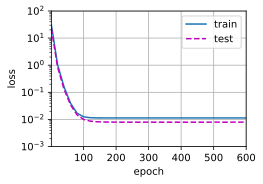

In [8]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],labels[:n_train], labels[n_train:])

可以看到，最后训练出来的权重，和真实的权重值，差距很小，这里，数据和模型是匹配的。
```python
true_w[0:4]=np.array([5,1.2,-3.4,5.6])
```

**然后数据使用一阶多项式（0阶和1阶），线性函数欠拟合，只给前两列数据**

+ 这里的w只有二个元素
+ 模型容量小（参数少），拟合能力差
+ 可以看到，损失非常高，差不多是5的感觉，1和10之间的位置，但是测试的损失就更高了，是50（10和100之间），都不行

weight: [[2.7853894 4.51728  ]]


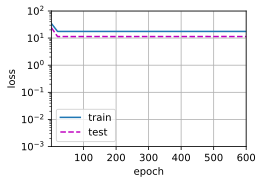

In [9]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],labels[:n_train], labels[n_train:])

**给定所有数据，0阶到19阶，数据中也含有噪音**
+ 这个运行看运气，有时候初始值很高，就不会过拟合，看不到泛化误差变高。。。
+ 模型不变的情况下，给出的数据更具有误导性/迷惑性，其实W除了前四个有值之外，后面都是0,
+ 但是可以看到，这个线性模型把噪音的0都拟合出来了。

目前看下来，只有老师讲课时候那个html文件是有过拟合了，其他包括在线的书，代码都不是过拟合的版本。。。
+ 老师讲课时使用的html文件：<http://courses.d2l.ai/zh-v2/assets/notebooks/chapter_multilayer-perceptrons/underfit-overfit.slides.html#/7>
    + 似乎是动态更新的，也没有过拟合那个现象了
+ 在线book对应的章节：<https://zh-v2.d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html#id16>

weight: [[ 5.0148072e+00  1.4581541e+00 -3.4770374e+00  4.5445366e+00
   5.5647099e-01  1.1833404e+00  5.1376313e-01  3.0686080e-01
   5.0430965e-02 -1.4106971e-01  1.7420676e-01 -2.6239034e-02
  -1.3922302e-01 -9.3657505e-03  6.2695391e-02  9.2644000e-04
  -1.9066702e-01 -6.1646074e-02  4.3345749e-02 -1.2799355e-01]]


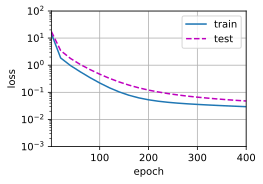

In [25]:
train(poly_features[:n_train, :], poly_features[n_train:, :],labels[:n_train], labels[n_train:])

## 代码解释

In [11]:
x1=np.array([0,1,2])
x2=np.array([1,2,3])
np.power(x1,x2)

array([0, 1, 8], dtype=int32)

np.power这个函数的作用就是把第二个参数作为幂次，作用到第一个参数上，逐元素进行幂次方。所以两个参数的形状必须相同，或者可以通过广播进行运算

In [12]:
a=np.arange(max_degree)
b=np.arange(max_degree).reshape(1,-1)
# 加reshape是为了多一层维度
print(a)
print(b)
print(b.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]]
(1, 20)


In [13]:
print(features.shape)
print(poly_features.shape)
# 200*1  幂次上 1*20 则对features中每个元素，都幂次上max_degree中的20个数字，得到20个结果。
id=2
print(features[id])
print(poly_features[id])
# 可以看到，其实就是对features中的每个元素，找出其0-19次方

torch.Size([200, 1])
torch.Size([200, 20])
tensor([-1.3285])
tensor([ 1.0000e+00, -1.3285e+00,  8.8242e-01, -3.9076e-01,  1.2978e-01,
        -3.4481e-02,  7.6345e-03, -1.4489e-03,  2.4060e-04, -3.5515e-05,
         4.7180e-06, -5.6980e-07,  6.3080e-08, -6.4461e-09,  6.1168e-10,
        -5.4173e-11,  4.4980e-12, -3.5150e-13,  2.5942e-14, -1.8138e-15])


In [14]:
math.gamma(1),math.gamma(2),math.gamma(3),

(1.0, 1.0, 2.0)

这个东西是伽马函数，可以去看看[百度百科的解释](https://baike.baidu.com/item/%E4%BC%BD%E7%8E%9B%E5%87%BD%E6%95%B0/3540177?fromtitle=gamma%E5%87%BD%E6%95%B0&fromid=10819772&fr=aladdin)，伽玛函数（Gamma Function）作为阶乘的延拓，是定义在复数范围内的亚纯函数